# Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from customized_library import plot_lib
from customized_library.models import best_model, best_model_loss
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, PolynomialFeatures, LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit, RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn import over_sampling
import tensorflow as tf

2024-03-21 14:53:54.406096: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-21 14:53:54.406144: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-21 14:53:54.407431: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-21 14:53:54.415440: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-21 14:53:55.654722: W tensorflow/compiler/tf2

In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
train = pd.read_csv('data/train.csv')
valid = pd.read_csv('data/validation.csv')
test = pd.read_csv('data/test.csv')

In [4]:
train.head()

,Edema_0,Edema_1,Spiders_ohe,Hepatomegaly_ohe,Ascites_ohe,Sex_ohe,Drug_ohe,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2256,17031,1.8,172.0,3.60,121.0,1072.0,110.05,96.0,248.0,10.6,2.0,CL
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2692,16990,1.1,460.0,3.22,75.0,1472.0,108.50,118.0,203.0,10.1,3.0,C
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2419,20354,0.9,364.0,3.48,20.0,1345.0,134.85,64.0,233.0,9.9,3.0,C
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,890,17320,7.2,201.0,3.53,159.0,1273.0,136.40,128.0,270.0,11.2,4.0,D
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2475,16050,0.9,204.0,3.65,44.0,1070.0,127.10,80.0,295.0,10.4,1.0,C


In [5]:
target = 'Status'

In [6]:
le = LabelEncoder()
train = pd.concat([train, pd.DataFrame(le.fit_transform(train[target].iloc[:].values), columns=[target+'_enc'])], axis=1)   
valid = pd.concat([valid, pd.DataFrame(le.transform(valid[target].iloc[:].values), columns=[target+'_enc'])], axis=1)     
test = pd.concat([test, pd.DataFrame(le.transform(test[target].iloc[:].values), columns=[target+'_enc'])], axis=1)

ohe = OneHotEncoder(sparse_output=False, drop=None)
train = pd.concat([train, pd.DataFrame(ohe.fit_transform(train[target+'_enc'].iloc[:].values.reshape(-1,1)), 
                                     columns=[target+'_enc0', target+'_enc1', target+'_enc2'])], axis=1)
train.drop([target], axis=1, inplace=True)
        
valid = pd.concat([valid, pd.DataFrame(ohe.transform(valid[target+'_enc'].iloc[:].values.reshape(-1,1)), 
                                          columns=[target+'_enc0', target+'_enc1', target+'_enc2'])], axis=1)
valid.drop([target], axis=1, inplace=True)
        
test= pd.concat([test, pd.DataFrame(ohe.transform(test[target+'_enc'].iloc[:].values.reshape(-1,1)), 
                                               columns=[target+'_enc0', target+'_enc1', target+'_enc2'])], axis=1)
test.drop([target], axis=1, inplace=True)

In [7]:
X_train, y_train_lab, y_train_ohe = train.iloc[:,:-4], train.iloc[:,-4], train.iloc[:,-3:]
X_valid, y_valid_lab, y_valid_ohe = valid.iloc[:,:-4], valid.iloc[:,-4,], valid.iloc[:,-3:]
X_test, y_test_lab, y_test_ohe = test.iloc[:,:-4], test.iloc[:,-4], test.iloc[:,-3:]

In [8]:
numerical_columns = ['N_Days', 'Age','Bilirubin','Cholesterol','Albumin','Copper','Alk_Phos','SGOT','Tryglicerides','Platelets','Prothrombin']
categorical_columns = [i for i in list(X_train.columns) if i not in numerical_columns ]

In [9]:
ss_x = StandardScaler()
X_train_s = pd.concat([pd.DataFrame(ss_x.fit_transform(X_train[numerical_columns]), columns=numerical_columns), X_train[categorical_columns]], axis=1)
X_valid_s = pd.concat([pd.DataFrame(ss_x.transform(X_valid[numerical_columns]), columns=numerical_columns), X_valid[categorical_columns]], axis=1)
X_test_s = pd.concat([pd.DataFrame(ss_x.transform(X_test[numerical_columns]), columns=numerical_columns), X_test[categorical_columns]], axis=1)

In [10]:
train.head()

,Edema_0,Edema_1,Spiders_ohe,Hepatomegaly_ohe,Ascites_ohe,Sex_ohe,Drug_ohe,N_Days,Age,Bilirubin,...,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status_enc,Status_enc0,Status_enc1,Status_enc2
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2256,17031,1.8,...,1072.0,110.05,96.0,248.0,10.6,2.0,1,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2692,16990,1.1,...,1472.0,108.50,118.0,203.0,10.1,3.0,0,1.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2419,20354,0.9,...,1345.0,134.85,64.0,233.0,9.9,3.0,0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,890,17320,7.2,...,1273.0,136.40,128.0,270.0,11.2,4.0,2,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2475,16050,0.9,...,1070.0,127.10,80.0,295.0,10.4,1.0,0,1.0,0.0,0.0


# Models

## models without oversampling

In [13]:
lr = LogisticRegression(random_state=42, solver='saga')
params = {'C':[0.001, 0.01, 0.1, 0.5 , 0.8, 1.0, 1.5], 'penalty': ['l1', 'l2']}
best_model_loss(X_train_s, y_train_lab, y_train_ohe, X_valid_s, y_valid_lab, y_valid_ohe, lr, params,threshold=0.5)

The best parameters of LogisticRegression,  C:  0.1    penalty:  l2    

              train     valid
loss       0.522030  0.518620
accuracy   0.791263  0.795257
precision  0.795234  0.761172
recall     0.791263  0.795257
f1_score   0.774254  0.774284


In [16]:
dt = DecisionTreeClassifier(random_state=42)
param = {'max_depth':[2, 4, 6, 8], 'splitter':['best', 'random']}
best_model_loss(X_train_s, y_train_lab, y_train_ohe, X_valid_s, y_valid_lab, y_valid_ohe, dt, param, threshold=0.1)

The best parameters of DecisionTreeClassifier,  max_depth:  4    splitter:  best    

              train     valid
loss       0.514612  0.530186
accuracy   0.799367  0.790514
precision  0.770470  0.757693
recall     0.799367  0.790514
f1_score   0.779369  0.767779


In [20]:
rf = RandomForestClassifier(random_state=42, criterion='entropy', bootstrap=False)
params = {'max_depth':[2, 4, 6, 8], 'n_estimators':[3, 7, 10, 15, 20]}
best_model_loss(X_train_s, y_train_lab, y_train_ohe, X_valid_s, y_valid_lab, y_valid_ohe, rf, params, threshold=0.05)

The best parameters of RandomForestClassifier,  max_depth:  4    n_estimators:  15    

              train     valid
loss       0.509189  0.525676
accuracy   0.813007  0.815810
precision  0.784043  0.784229
recall     0.813007  0.815810
f1_score   0.794122  0.792683


In [25]:
svc = SVC(random_state=42, probability=True)
params = {'kernel':['rbf', 'poly', 'linear'], 'C':[0.5, 1.0, 1.5]}
best_model_loss(X_train_s, y_train_lab, y_train_ohe, X_valid_s, y_valid_lab, y_valid_ohe, svc, params, threshold=0.9)

The best parameters of SVC,  kernel:  rbf    C:  1.0    

              train     valid
loss       0.462553  0.513607
accuracy   0.822297  0.817391
precision  0.821094  0.797832
recall     0.823483  0.816601
f1_score   0.809621  0.797257


In [33]:
gb = GradientBoostingClassifier(random_state=42, loss='log_loss')
params = {'learning_rate':[0.01, 0.1, 0.5, 1.], 'n_estimators':[100, 140, 180, 220], 'max_depth':[3, 5, 7]}
best_model_loss(X_train_s, y_train_lab, y_train_ohe, X_valid_s, y_valid_lab, y_valid_ohe, gb, params, threshold=0.5)

The best parameters of GradientBoostingClassifier,  learning_rate:  0.1    n_estimators:  180    max_depth:  3    

              train     valid
loss       0.294729  0.436706
accuracy   0.886934  0.837154
precision  0.886530  0.831306
recall     0.886934  0.837154
f1_score   0.883838  0.827358


In [29]:
knn = KNeighborsClassifier()
params = {'n_neighbors':[3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25], 'p':[1,2]}
best_model_loss(X_train_s, y_train_lab, y_train_ohe, X_valid_s, y_valid_lab, y_valid_ohe, knn, params, threshold=0.5)

The best parameters of KNeighborsClassifier,  n_neighbors:  23    p:  2    

              train     valid
loss       0.462024  0.961729
accuracy   0.802332  0.784980
precision  0.775823  0.756490
recall     0.802332  0.784980
f1_score   0.781962  0.760805


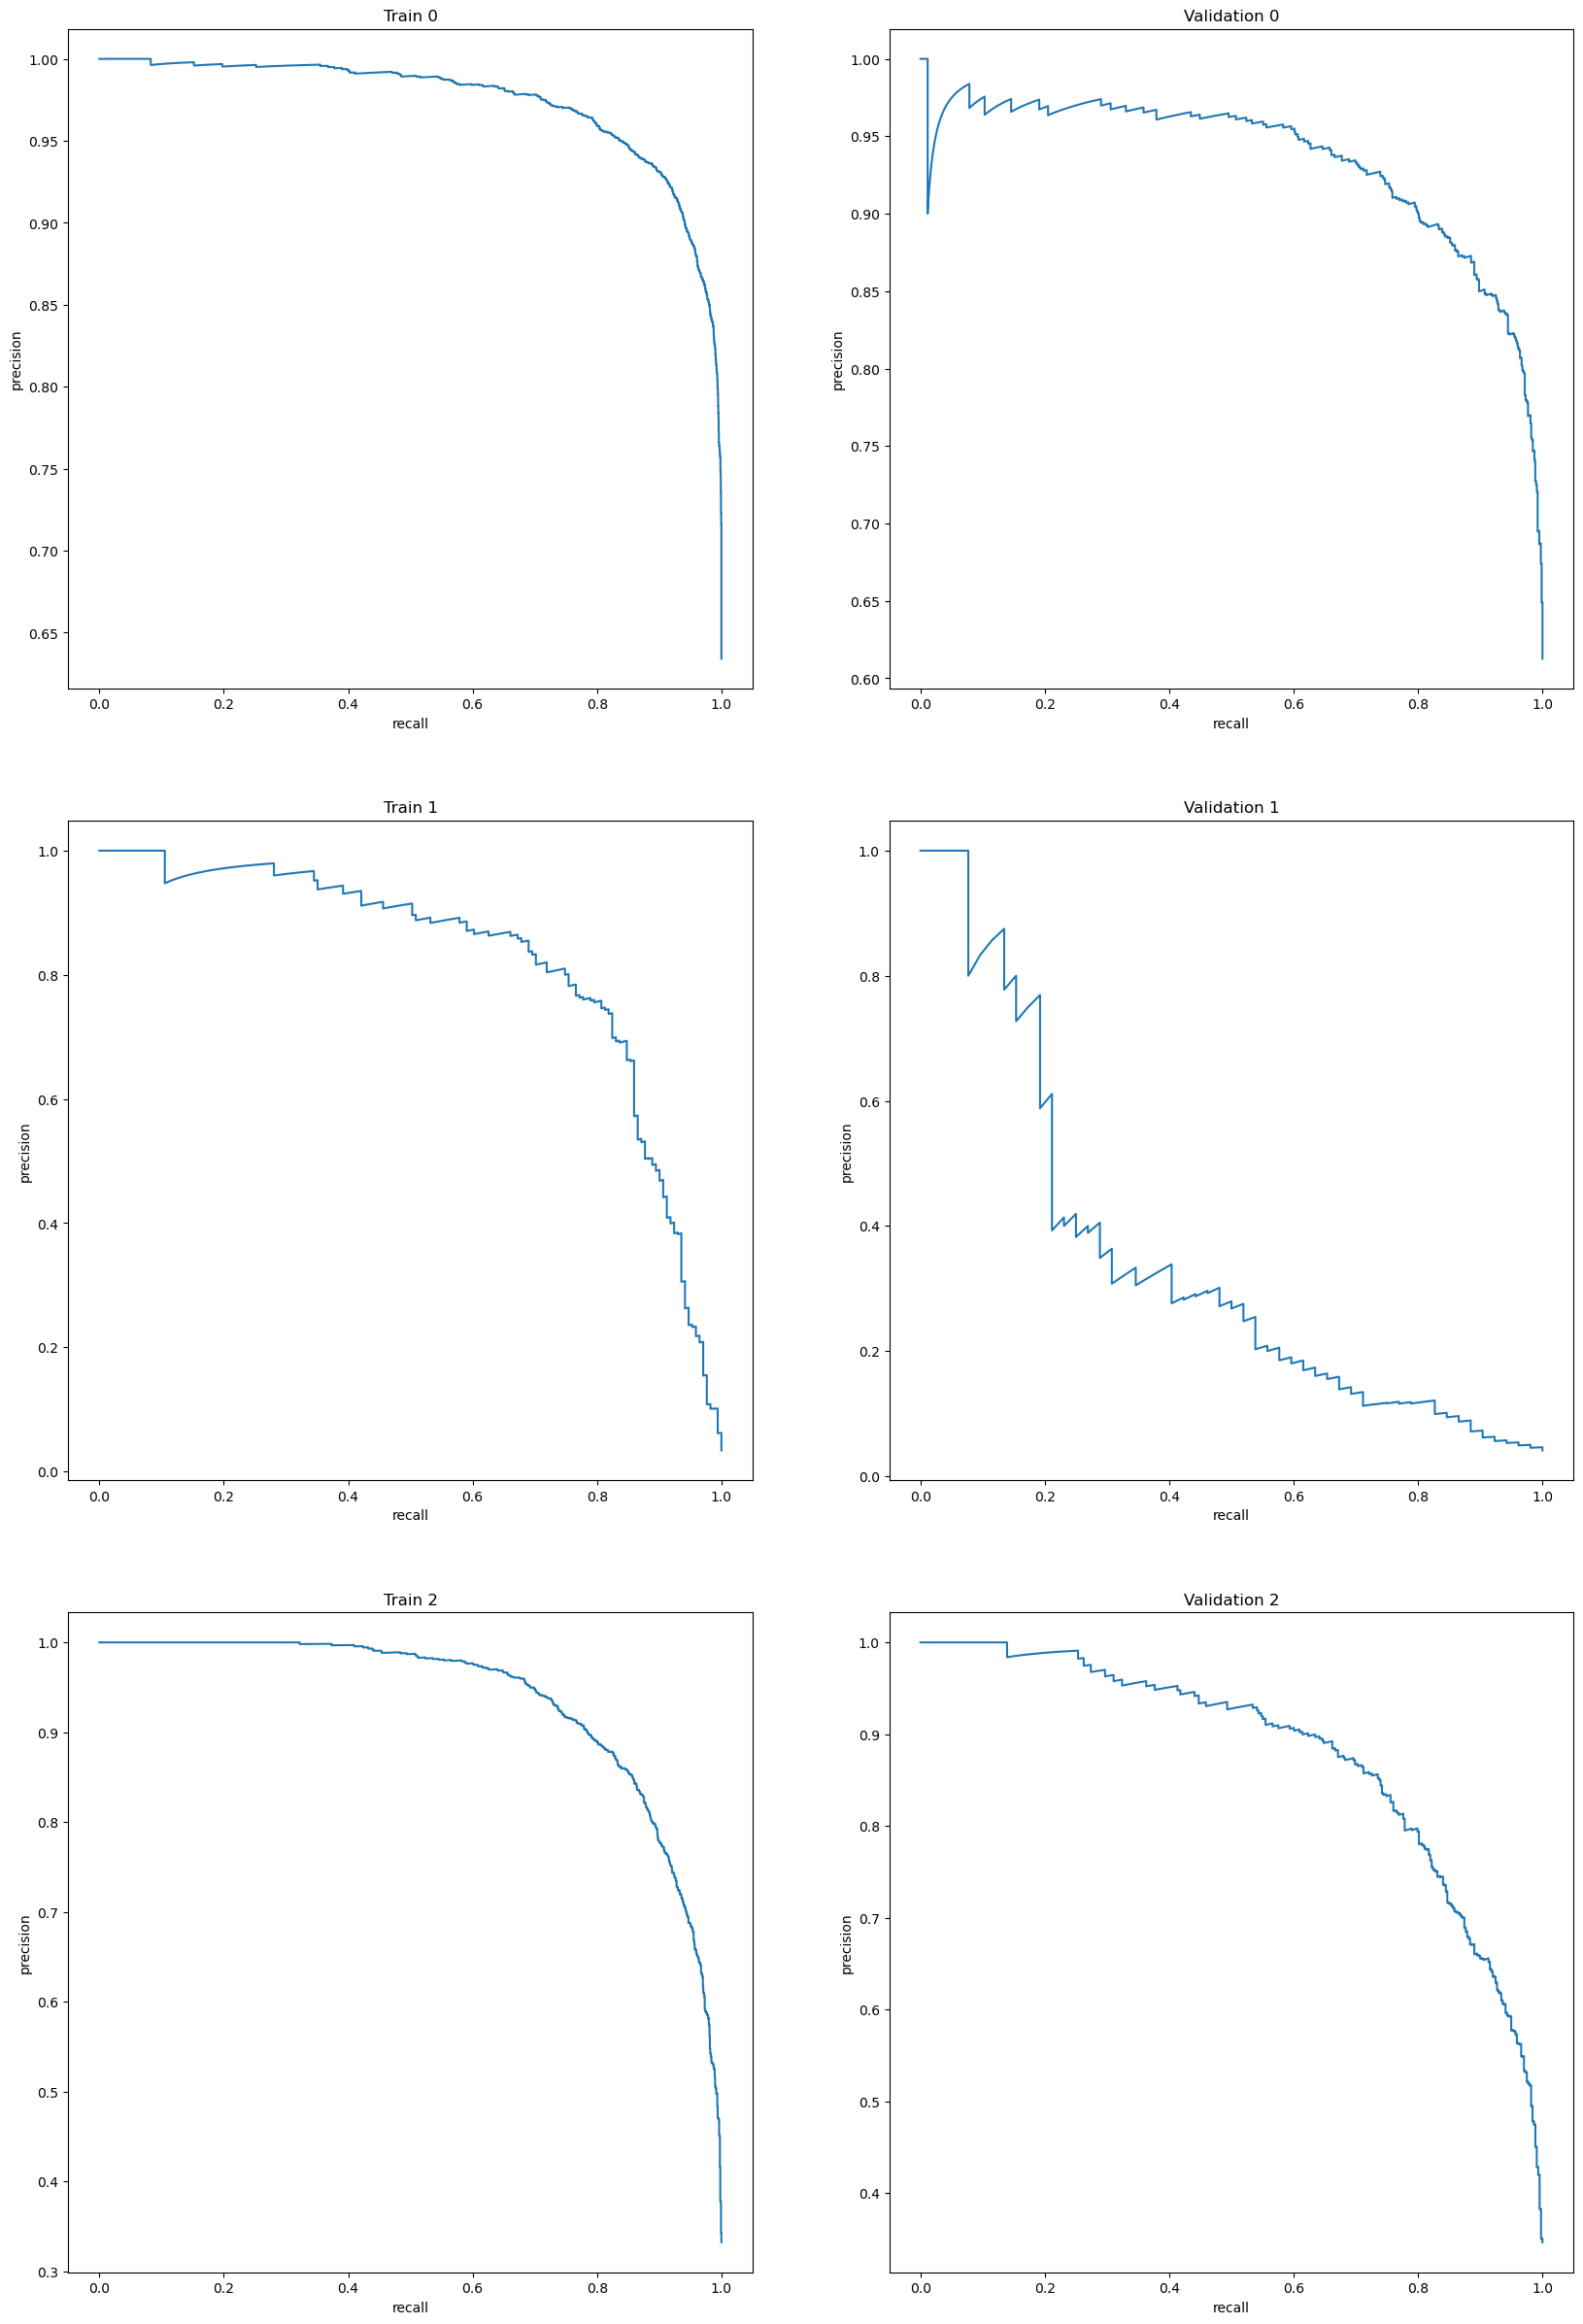

In [34]:
bm_without_oversamp = GradientBoostingClassifier(random_state=42, loss='log_loss', learning_rate = 0.1, n_estimators = 180, max_depth = 3)
y_train_pred, y_valid_pred, model = plot_lib.train(bm_without_oversamp, X_train_s, y_train_lab, X_valid_s)
plot_lib.plot_precision_recall_curve(y_train_ohe,model.predict_proba(X_train_s), y_valid_ohe, model.predict_proba(X_valid_s))

## models with manipulated features

In [35]:
p_x = PolynomialFeatures(degree=2, include_bias=False)
num_poly_columns=['poly_'+str(i) for i in range(77)]

X_train_p = pd.concat([pd.DataFrame(p_x.fit_transform(X_train[numerical_columns]), columns=num_poly_columns), X_train[categorical_columns]], axis=1)
X_valid_p = pd.concat([pd.DataFrame(p_x.transform(X_valid[numerical_columns]), columns=num_poly_columns), X_valid[categorical_columns]], axis=1)

In [36]:
ss_x = StandardScaler()
X_train_p_s = pd.concat([pd.DataFrame(ss_x.fit_transform(X_train_p[num_poly_columns]), columns=num_poly_columns), X_train[categorical_columns]], axis=1)
X_valid_p_s = pd.concat([pd.DataFrame(ss_x.fit_transform(X_valid_p[num_poly_columns]), columns=num_poly_columns), X_valid[categorical_columns]], axis=1)

In [41]:
lr = LogisticRegression(random_state=42, solver='saga')
params = {'C':[0.001, 0.01, 0.1, 0.5 , 0.8, 1.0, 1.5], 'penalty': ['l1', 'l2']}
best_model_loss(X_train_p_s, y_train_lab, y_train_ohe, X_valid_p_s, y_valid_lab, y_valid_ohe, lr, params,threshold=0.01)

The best parameters of LogisticRegression,  C:  0.01    penalty:  l2    

              train     valid
loss       0.503026  0.512283
accuracy   0.803321  0.803953
precision  0.807302  0.770343
recall     0.803321  0.803953
f1_score   0.786469  0.782693


In [38]:
rf = RandomForestClassifier(random_state=42, criterion='entropy', bootstrap=False)
params = {'max_depth':[2, 4, 6, 8], 'n_estimators':[3, 7, 10, 15, 20, 25]}
best_model_loss(X_train_p_s, y_train_lab, y_train_ohe, X_valid_p_s, y_valid_lab, y_valid_ohe, rf, params,threshold=0.05)

The best parameters of RandomForestClassifier,  max_depth:  4    n_estimators:  15    

              train     valid
loss       0.496504  0.518634
accuracy   0.814193  0.803162
precision  0.784674  0.767752
recall     0.814193  0.803162
f1_score   0.798684  0.783207


In [39]:
svc = SVC(random_state=42, probability=True)
params = {'kernel':['rbf', 'poly', 'linear'], 'C':[0.01, 0.1, 0.5, 1.0]}
best_model_loss(X_train_p_s, y_train_lab, y_train_ohe, X_valid_p_s, y_valid_lab, y_valid_ohe, svc, params,threshold=0.01)

The best parameters of SVC,  kernel:  linear    C:  0.01    

              train     valid
loss       0.518799  0.516585
accuracy   0.806879  0.803162
precision  0.777386  0.770575
recall     0.807076  0.803953
f1_score   0.789637  0.782300


In [42]:
gb = GradientBoostingClassifier(random_state=42, loss='log_loss')
params = {'learning_rate':[0.01, 0.1, 0.5, 1.], 'n_estimators':[100, 140, 180], 'max_depth':[3, 5, 7]}
best_model_loss(X_train_p_s, y_train_lab, y_train_ohe, X_valid_p_s, y_valid_lab, y_valid_ohe, gb, params,threshold=0.5)

The best parameters of GradientBoostingClassifier,  learning_rate:  0.1    n_estimators:  100    max_depth:  3    

              train     valid
loss       0.328578  0.473976
accuracy   0.873888  0.815810
precision  0.873402  0.800977
recall     0.873888  0.815810
f1_score   0.869195  0.802441


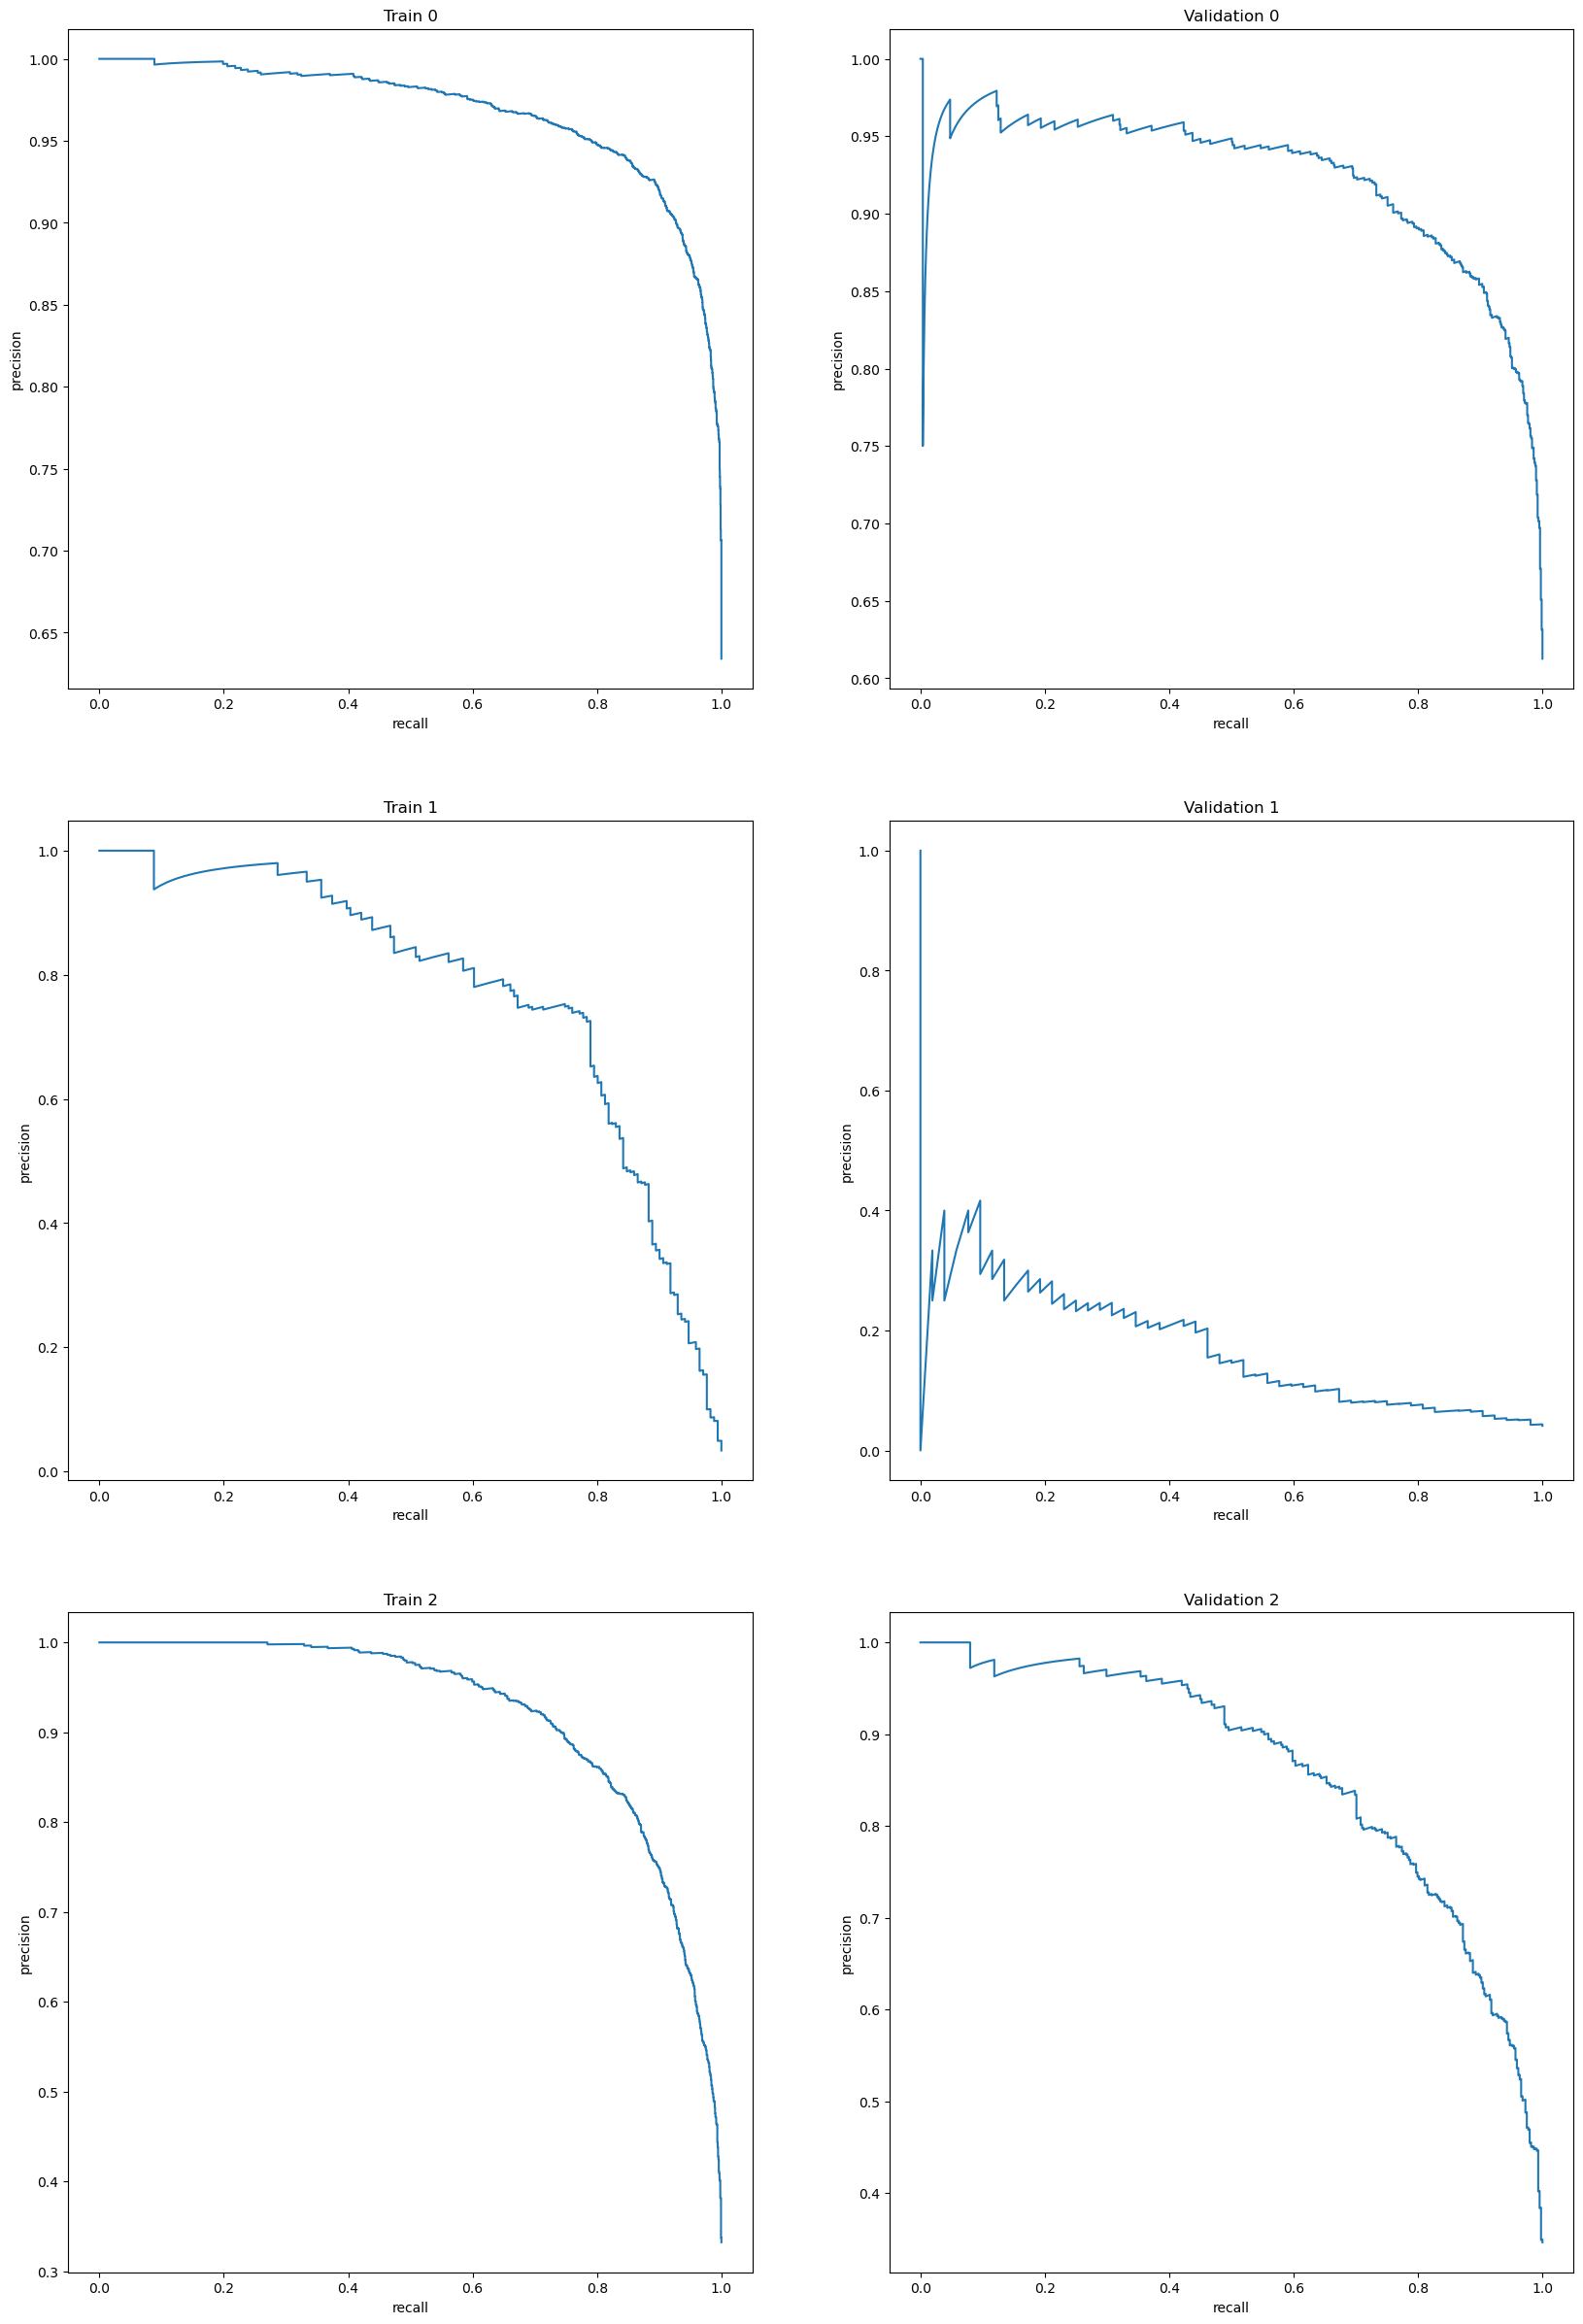

In [46]:
bm_manip_f = GradientBoostingClassifier(random_state=42, loss='log_loss', learning_rate = 0.1, n_estimators = 100, max_depth = 3)
y_train_pred, y_valid_pred, model = plot_lib.train(bm_manip_f, X_train_p_s, y_train_lab, X_valid_p_s)
plot_lib.plot_precision_recall_curve(y_train_ohe,model.predict_proba(X_train_p_s), y_valid_ohe, model.predict_proba(X_valid_p_s))

## models with oversampling

In [47]:
sm = over_sampling.SMOTE(random_state=42, k_neighbors=7)
a = sm.fit_resample(X_train_s.iloc[:,:].values, y_train_lab.iloc[:].values.reshape(-1,1))

In [48]:
X_train_sm = pd.DataFrame(a[0], columns=X_train_s.columns.tolist())
y_train_sm = pd.DataFrame(a[1], columns=[train.iloc[:,-4].name])

In [49]:
y_train_sm.value_counts()

Status_enc
0             3208
1             3208
2             3208
Name: count, dtype: int64

In [50]:
y_train_sm_encoder = pd.DataFrame(ohe.transform(y_train_sm.iloc[:].values.reshape(-1,1)), columns=['d', 'c', 'cl'])

In [51]:
lr = LogisticRegression(random_state=42, solver='saga')
params = {'C':[0.001, 0.01, 0.1, 0.5 , 0.8, 1.0, 1.5], 'penalty': ['l1', 'l2']}
best_model_loss(X_train_sm, y_train_sm, y_train_sm_encoder, X_valid_s, y_valid_lab, y_valid_ohe, lr, params,threshold=0.01)

The best parameters of LogisticRegression,  C:  0.1    penalty:  l1    

              train     valid
loss       0.771429  0.754893
accuracy   0.676330  0.656917
precision  0.677333  0.793857
recall     0.676330  0.656917
f1_score   0.676452  0.710383


In [53]:
rf = RandomForestClassifier(random_state=42, criterion='entropy', bootstrap=False)
params = {'max_depth':[2, 4, 6, 8], 'n_estimators':[3, 7, 10, 15, 20, 25]}
best_model_loss(X_train_sm, y_train_sm['Status_enc'], y_train_sm_encoder, X_valid_s, y_valid_lab, y_valid_ohe, rf, params,threshold=0.01)

The best parameters of RandomForestClassifier,  max_depth:  4    n_estimators:  25    

              train     valid
loss       0.715512  0.719835
accuracy   0.736804  0.721739
precision  0.736605  0.798905
recall     0.736804  0.721739
f1_score   0.736314  0.753608


In [55]:
gb = GradientBoostingClassifier(random_state=42, loss='log_loss')
params = {'learning_rate':[0.01, 0.1, 0.5, 1.], 'n_estimators':[100, 140, 180], 'max_depth':[3, 5, 7]}
best_model_loss(X_train_sm, y_train_sm['Status_enc'], y_train_sm_encoder, X_valid_s, y_valid_lab, y_valid_ohe, gb, params,threshold=0.5)

The best parameters of GradientBoostingClassifier,  learning_rate:  0.1    n_estimators:  180    max_depth:  5    

              train     valid
loss       0.122041  0.465782
accuracy   0.976829  0.822134
precision  0.976803  0.814120
recall     0.976829  0.822134
f1_score   0.976798  0.817460


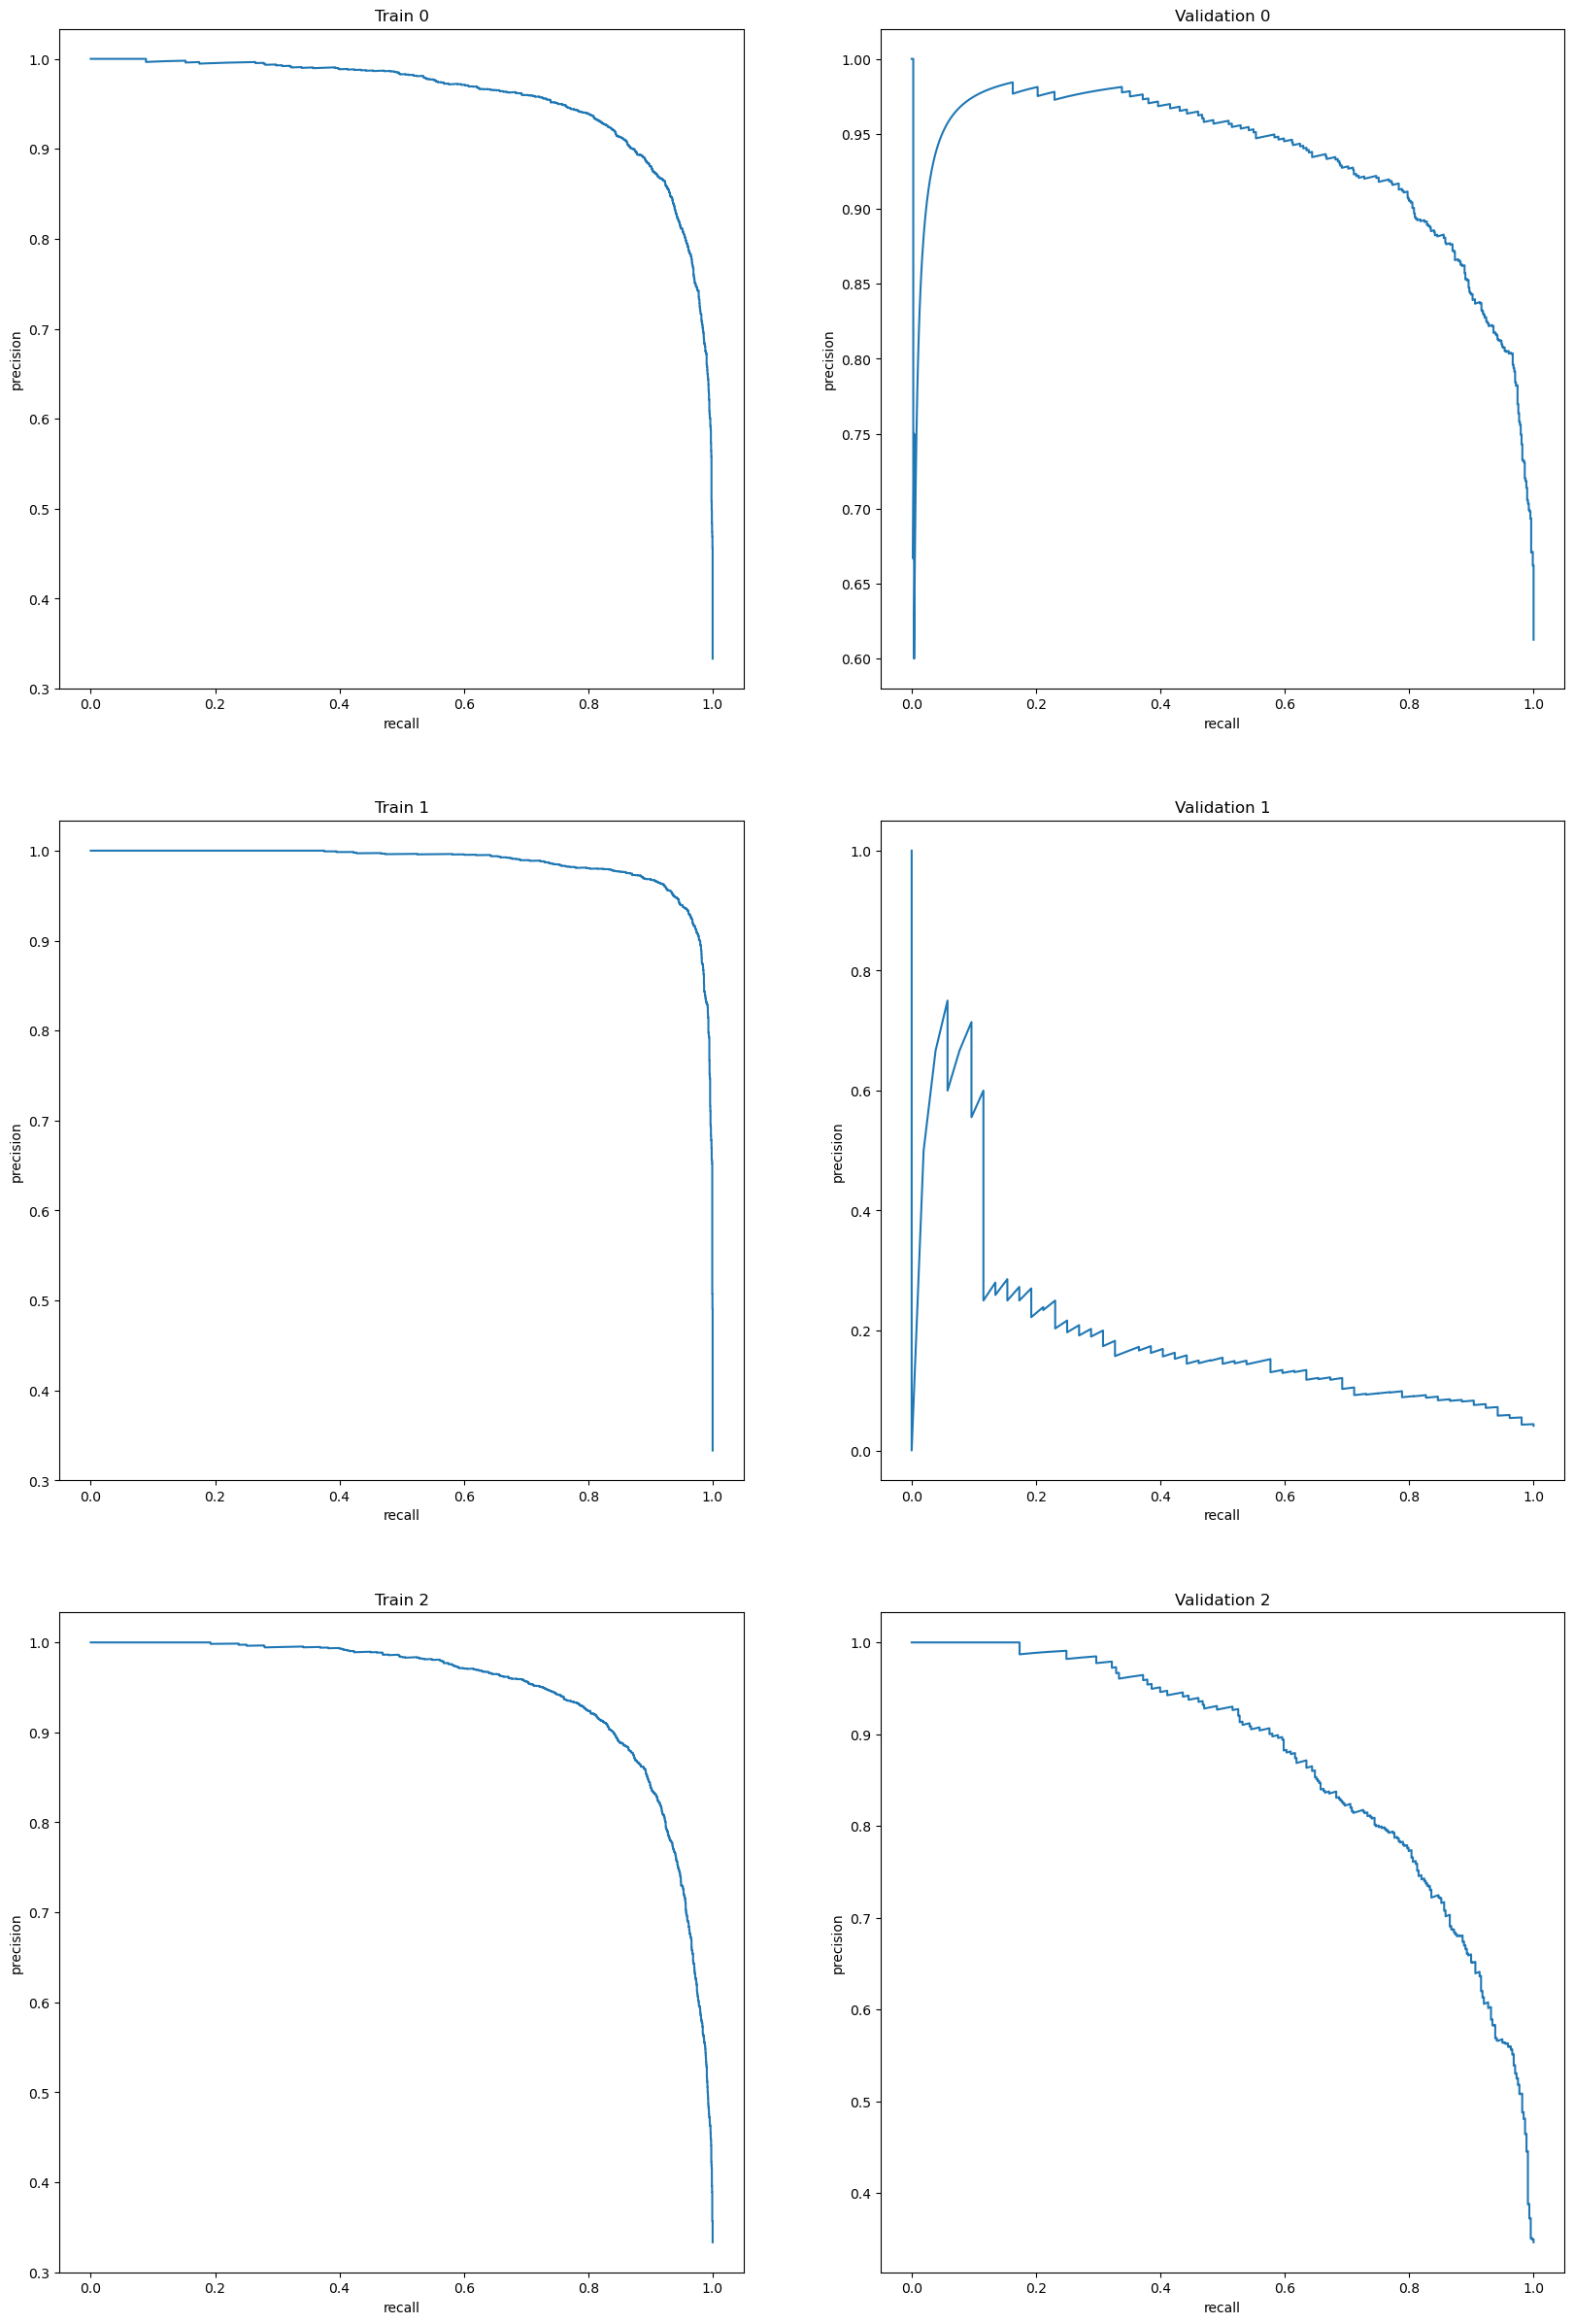

In [56]:
bm_with_oversamp = GradientBoostingClassifier(random_state=42, loss='log_loss', learning_rate = 0.1, n_estimators = 180, max_depth = 3)
y_train_pred, y_valid_pred, model = plot_lib.train(bm_with_oversamp, X_train_sm, y_train_sm['Status_enc'], X_valid_s)
plot_lib.plot_precision_recall_curve(y_train_sm_encoder,model.predict_proba(X_train_sm), y_valid_ohe, model.predict_proba(X_valid_s))

## models with ANN

In [71]:
input_x = tf.keras.Input(shape=(X_train_s.shape[1],))
x = tf.keras.layers.Dense(20)(input_x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(30, activation='leaky_relu')(x)
x = tf.keras.layers.BatchNormalization(center=False)(x)
# x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(30, activation='leaky_relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(3, activation='softmax')(x)

model = tf.keras.Model(input_x, output)

In [72]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.metrics.Precision(), tf.metrics.Recall()])

In [73]:
history = model.fit(X_train_s, y_train_ohe, epochs=1500, batch_size=32, validation_data=(X_valid_s, y_valid_ohe), verbose=1)

Epoch 1/1500
159/159 [==============================] - 2s 4ms/step - loss: 0.7692 - accuracy: 0.6986 - precision_1: 0.7266 - recall_1: 0.6266 - val_loss: 0.5867 - val_accuracy: 0.7802 - val_precision_1: 0.8131 - val_recall_1: 0.6877
Epoch 2/1500
159/159 [==============================] - 0s 2ms/step - loss: 0.6323 - accuracy: 0.7545 - precision_1: 0.7739 - recall_1: 0.7124 - val_loss: 0.5415 - val_accuracy: 0.7992 - val_precision_1: 0.8267 - val_recall_1: 0.7542
Epoch 3/1500
159/159 [==============================] - 0s 2ms/step - loss: 0.6050 - accuracy: 0.7675 - precision_1: 0.7865 - recall_1: 0.7355 - val_loss: 0.5293 - val_accuracy: 0.8000 - val_precision_1: 0.8229 - val_recall_1: 0.7676
Epoch 4/1500
159/159 [==============================] - 0s 2ms/step - loss: 0.5935 - accuracy: 0.7687 - precision_1: 0.7867 - recall_1: 0.7409 - val_loss: 0.5332 - val_accuracy: 0.8040 - val_precision_1: 0.8301 - val_recall_1: 0.7763
Epoch 5/1500
159/159 [==============================] - 0s 2ms/s

In [74]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision_1', 'recall_1', 'val_loss', 'val_accuracy', 'val_precision_1', 'val_recall_1'])

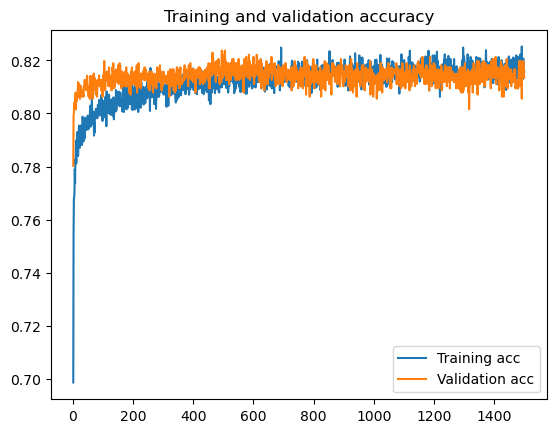

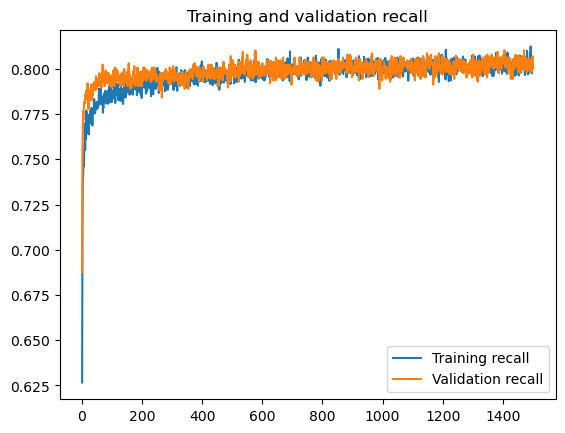

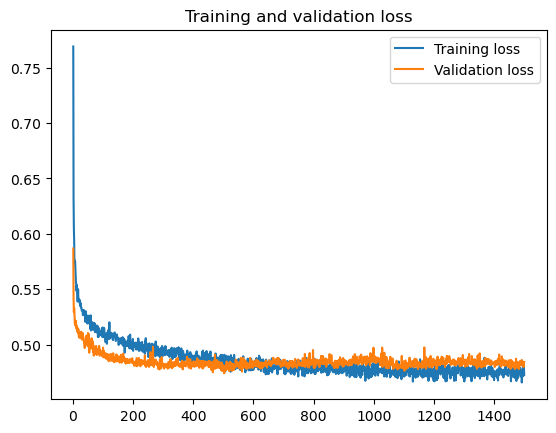

In [76]:
epochs = range(1, len(history.history['accuracy']) + 1)

plt.plot(epochs, history.history['accuracy'], label='Training acc')
plt.plot(epochs, history.history['val_accuracy'], label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, history.history['recall_1'], label='Training recall')
plt.plot(epochs, history.history['val_recall_1'], label='Validation recall')
plt.title('Training and validation recall')
plt.legend()

plt.figure()

plt.plot(epochs, history.history['loss'], label='Training loss')
plt.plot(epochs, history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [77]:
print('train loss: {},   validation loss:  {}'.format(history.history['loss'][-1], history.history['val_loss'][-1]))

train loss: 0.47260355949401855,   validation loss:  0.48443129658699036


40/40 [==============================] - 0s 1ms/step


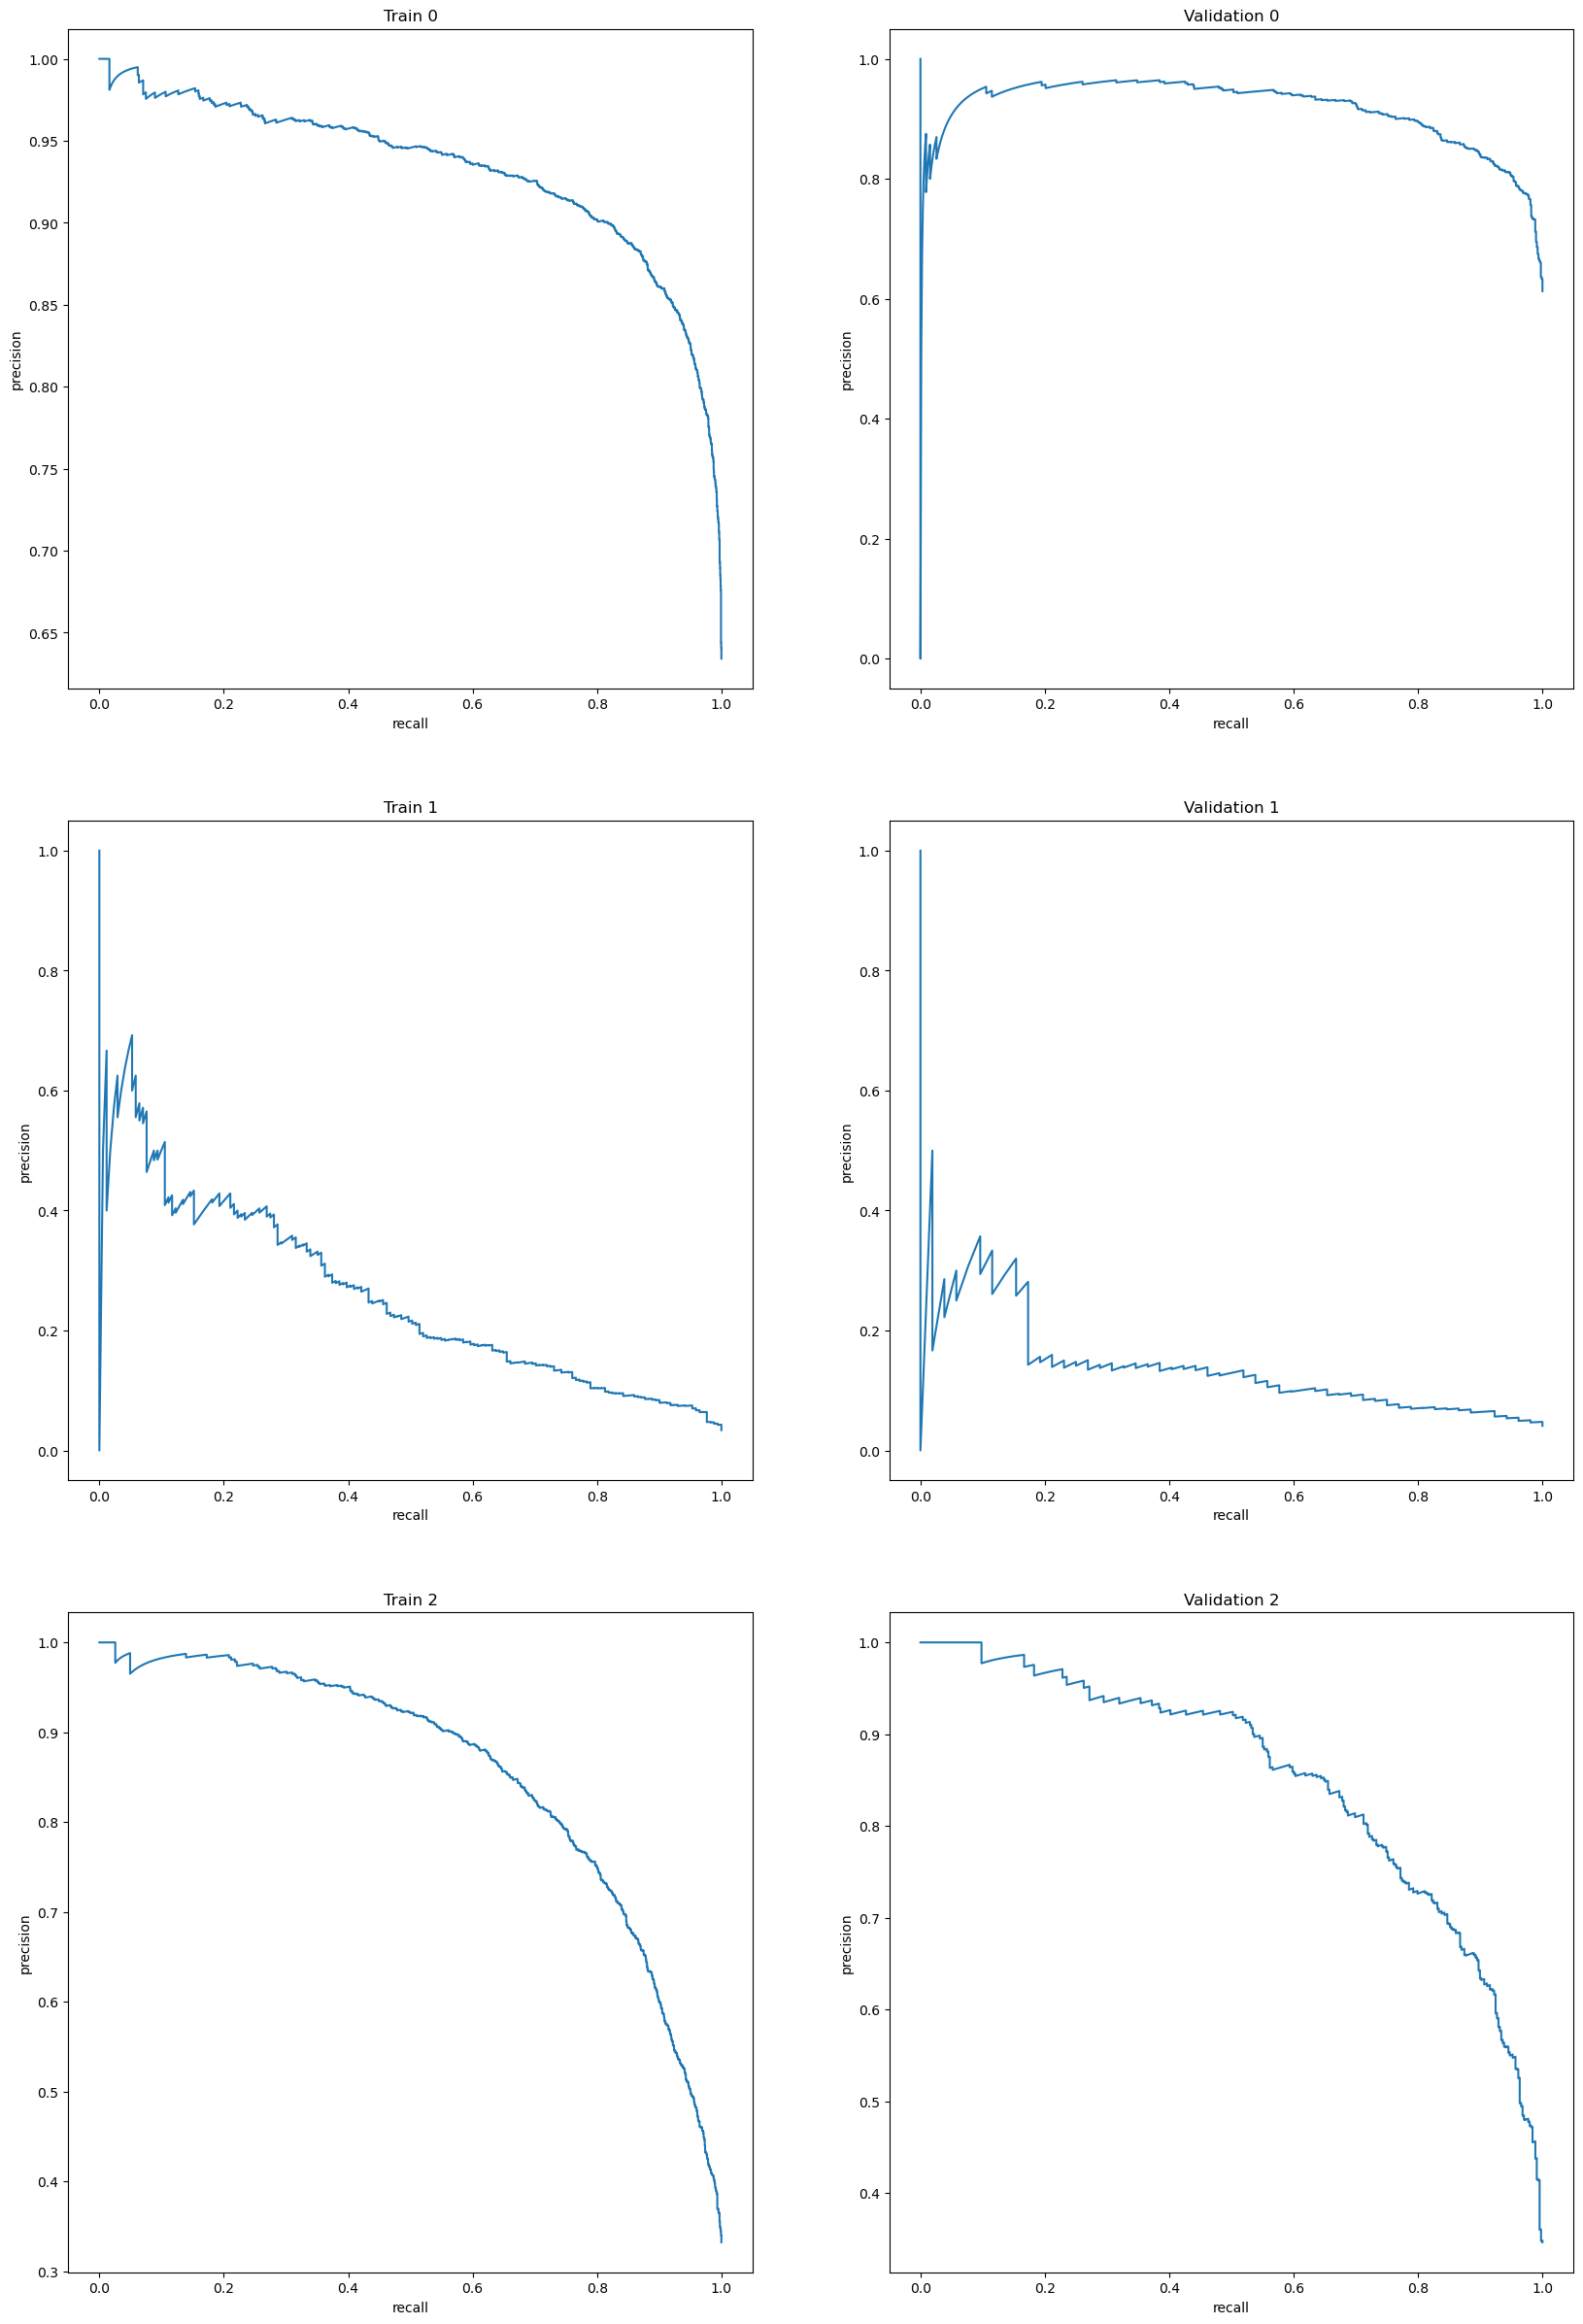

In [78]:
plot_lib.plot_precision_recall_curve(y_train_ohe,model.predict(X_train_s.iloc[:,:].values), y_valid_ohe, model.predict(X_valid_s))